Cell 1: Install and Import Necessary Libraries

In [7]:
# Install necessary libraries
!pip install yfinance pandas numpy scipy statsmodels matplotlib requests

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
import requests

Cell 2: Define Functions for Data Collection and Analysis

In [8]:
# Function to download data from Yahoo Finance
def download_data(ticker, start, end):
    return yf.download(ticker, start=start, end=end)

# Function to fetch data from IMF API
def fetch_imf_data(database_id, frequency, item, area, start_period, end_period):
    url = f"http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/{database_id}/{frequency}.{area}.{item}?startPeriod={start_period}&endPeriod={end_period}"
    response = requests.get(url)
    data = response.json()
    return data

# Function to convert IMF data to DataFrame and filter by USD unit measure
def imf_data_to_dataframe(data):
    pmilk_data = []
    series = data['CompactData']['DataSet']['Series']
    for entry in series:
        if entry.get('@COMMODITY') == 'PMILK' and entry.get('@UNIT_MEASURE') == 'USD':
            for obs in entry['Obs']:
                pmilk_data.append({'@TIME_PERIOD': obs['@TIME_PERIOD'], '@OBS_VALUE': float(obs['@OBS_VALUE'])})
    df = pd.DataFrame(pmilk_data)
    df['@TIME_PERIOD'] = pd.to_datetime(df['@TIME_PERIOD'])
    df.set_index('@TIME_PERIOD', inplace=True)
    df.rename(columns={'@OBS_VALUE': 'Spot Price'}, inplace=True)
    return df

# Function to calculate returns
def calculate_returns(prices):
    return prices.pct_change().dropna()

# Function to calculate basis
def calculate_basis(spot, futures):
    return spot - futures

# Function to calculate EWMA volatility
def ewma_volatility(returns, lambda_=0.97):
    ewma_var = returns.ewm(alpha=(1 - lambda_)).var()
    return np.sqrt(ewma_var)

# Function to calculate Myers and Thompson hedge ratio
def myers_thompson_hedge_ratio(spot_returns, futures_returns):
    cov = spot_returns.rolling(window=12).cov(futures_returns)
    var_futures = futures_returns.rolling(window=12).var()
    return cov / var_futures

# Function to calculate VaR
def calculate_var(returns, confidence_level=0.05):
    mean = returns.mean()
    std = returns.std()
    return norm.ppf(confidence_level, mean, std)

# Function to calculate Monte Carlo VaR
def monte_carlo_var(returns, confidence_level=0.05, simulations=1000):
    simulated_returns = np.random.choice(returns, size=(simulations, len(returns)), replace=True)
    simulated_var = np.percentile(simulated_returns.sum(axis=1), confidence_level * 100)
    return simulated_var

Cell 3: Download and Test Data

In [9]:
# Define parameters
start_date = '2020-01-01'
end_date = '2023-01-01'
futures_ticker = 'DC=F'  # Class III Milk Futures

# Fetch spot data from IMF API
imf_data = fetch_imf_data(database_id='PCPS', frequency='M', item='PMILK', area='W00', start_period=start_date, end_period=end_date)
spot_df = imf_data_to_dataframe(imf_data)
print(spot_df.head())

# Download futures data
futures_data = download_data(futures_ticker, start=start_date, end=end_date)
print(futures_data.head())

# Resample futures data to get monthly closing prices
futures_data_monthly = futures_data['Adj Close'].resample('M').last()
print(futures_data_monthly.head())

# Reindex spot prices to the same dates as futures prices
spot_df_reindexed = spot_df.reindex(futures_data_monthly.index, method='nearest')

# Align the spot and futures data
aligned_data = pd.merge(spot_df_reindexed, futures_data_monthly, left_index=True, right_index=True, how='inner')
spot_prices_aligned = aligned_data['Spot Price']
futures_prices_aligned = aligned_data['Adj Close']

# Test data
print("Spot Prices Aligned:")
print(spot_prices_aligned.head())
print("Futures Prices Aligned:")
print(futures_prices_aligned.head())


[*********************100%%**********************]  1 of 1 completed

              Spot Price
@TIME_PERIOD            
2020-01-01     17.115645
2020-02-01     17.001998
2020-03-01     16.357273
2020-04-01     13.424545
2020-05-01     11.961429
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2020-01-02  19.370001  19.370001  19.370001  19.370001  19.370001     464
2020-01-03  17.110001  17.150000  16.870001  16.930000  16.930000     479
2020-01-06  16.950001  17.000000  16.900000  16.969999  16.969999     299
2020-01-07  17.020000  17.139999  17.000000  17.100000  17.100000     261
2020-01-08  17.139999  17.150000  16.940001  17.000000  17.000000     343
Date
2020-01-31    17.040001
2020-02-29    16.980000
2020-03-31    16.219999
2020-04-30    11.370000
2020-05-31    12.180000
Freq: M, Name: Adj Close, dtype: float64
Spot Prices Aligned:
Date
2020-01-31    17.001998
2020-02-29    16.357273
2020-03-31    13.424545
2020-04-30    11.961429
2020-05-31    19.85

Cell 4: Calculate Returns and Basis

In [10]:
# Calculate returns for spot and futures prices
spot_returns = calculate_returns(spot_prices_aligned)
futures_returns = calculate_returns(futures_prices_aligned)

# Calculate basis
basis = calculate_basis(spot_prices_aligned, futures_prices_aligned)
print("Basis:")
print(basis.head())

Basis:
Date
2020-01-31   -0.038003
2020-02-29   -0.622726
2020-03-31   -2.795454
2020-04-30    0.591429
2020-05-31    7.677273
Freq: M, dtype: float64


Cell 5: Estimate Hedge Ratios and Calculate VaR

In [11]:
# Calculate rolling covariance and variance
rolling_cov = spot_returns.rolling(window=12).cov(futures_returns)
rolling_var_futures = futures_returns.rolling(window=12).var()

# Print rolling covariance and variance for diagnostics
print("Rolling Covariance:")
print(rolling_cov.dropna().head())
print("Rolling Variance of Futures:")
print(rolling_var_futures.dropna().head())

# Estimate hedge ratios
mt_hedge_ratio = myers_thompson_hedge_ratio(spot_returns, futures_returns)
ewma_hedge_ratio = ewma_volatility(futures_returns)

# Print hedge ratios for diagnostics
print("Myers and Thompson Hedge Ratio:")
print(mt_hedge_ratio.dropna().head())
print("EWMA Hedge Ratio:")
print(ewma_hedge_ratio.dropna().head())

# Apply hedge ratios to returns
hedged_returns_mt = spot_returns - mt_hedge_ratio * futures_returns
hedged_returns_ewma = spot_returns - ewma_hedge_ratio * futures_returns

# Handle any NaN values in hedged returns
hedged_returns_mt = hedged_returns_mt.dropna()
hedged_returns_ewma = hedged_returns_ewma.dropna()

# Calculate VaR
var_cash = calculate_var(spot_returns)
var_hedged_mt = calculate_var(hedged_returns_mt) if not hedged_returns_mt.empty else np.nan
var_hedged_ewma = calculate_var(hedged_returns_ewma) if not hedged_returns_ewma.empty else np.nan
mc_var_cash = monte_carlo_var(spot_returns)
mc_var_hedged_mt = monte_carlo_var(hedged_returns_mt) if not hedged_returns_mt.empty else np.nan
mc_var_hedged_ewma = monte_carlo_var(hedged_returns_ewma) if not hedged_returns_ewma.empty else np.nan

Rolling Covariance:
Date
2021-01-31    0.017567
2021-02-28    0.017326
2021-03-31    0.015874
2021-04-30    0.010806
2021-05-31    0.010465
Freq: M, dtype: float64
Rolling Variance of Futures:
Date
2021-01-31    0.082837
2021-02-28    0.083055
2021-03-31    0.082552
2021-04-30    0.071697
2021-05-31    0.071703
Freq: M, Name: Adj Close, dtype: float64
Myers and Thompson Hedge Ratio:
Date
2021-01-31    0.212070
2021-02-28    0.208608
2021-03-31    0.192288
2021-04-30    0.150719
2021-05-31    0.145946
Freq: M, dtype: float64
EWMA Hedge Ratio:
Date
2020-03-31    0.029159
2020-04-30    0.161019
2020-05-31    0.162239
2020-06-30    0.387603
2020-07-31    0.345319
Freq: M, Name: Adj Close, dtype: float64



Cell 6: Analysis and Visualization

VaR (Cash): -0.2359719437868401
VaR (Hedged MT): -0.07458146117262276
VaR (Hedged EWMA): -0.2467972537789656
Monte Carlo VaR (Cash): -0.7212028024089367
Monte Carlo VaR (Hedged MT): 0.03880980706089735
Monte Carlo VaR (Hedged EWMA): -0.950314280898204


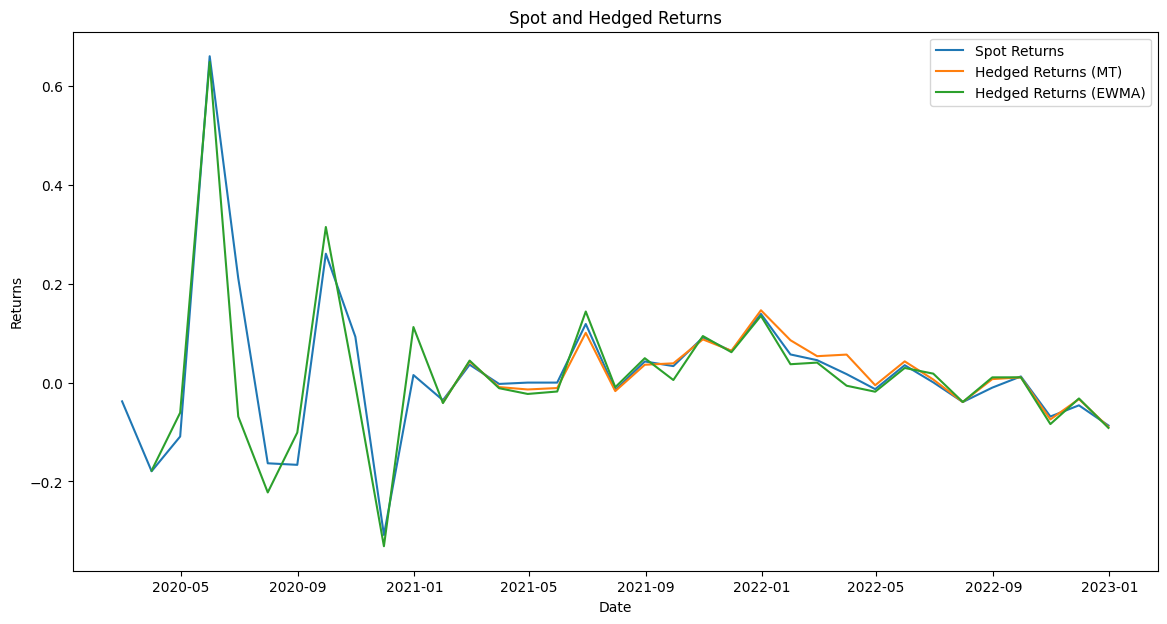

In [12]:
# Results
print("VaR (Cash):", var_cash)
print("VaR (Hedged MT):", var_hedged_mt if not np.isnan(var_hedged_mt) else 'N/A')
print("VaR (Hedged EWMA):", var_hedged_ewma if not np.isnan(var_hedged_ewma) else 'N/A')
print("Monte Carlo VaR (Cash):", mc_var_cash)
print("Monte Carlo VaR (Hedged MT):", mc_var_hedged_mt if not np.isnan(mc_var_hedged_mt) else 'N/A')
print("Monte Carlo VaR (Hedged EWMA):", mc_var_hedged_ewma if not np.isnan(mc_var_hedged_ewma) else 'N/A')

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(spot_returns, label='Spot Returns')
plt.plot(hedged_returns_mt, label='Hedged Returns (MT)')
plt.plot(hedged_returns_ewma, label='Hedged Returns (EWMA)')
plt.legend()
plt.title('Spot and Hedged Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()
